In [2]:
import sys
sys.path.append('../')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.segmentation import load_image

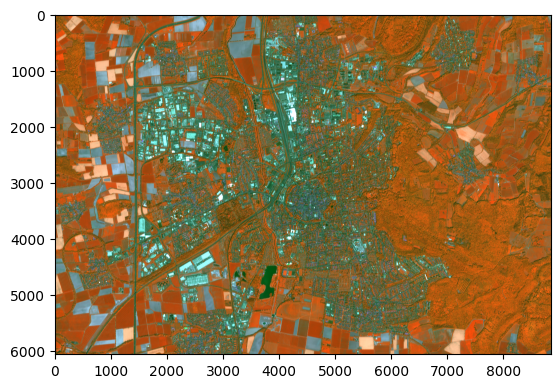

In [35]:
from math import ceil

whole_map = load_image('../data/bronze/whole_city/', 'Goettingen_Sentinel2_20220509.tif')
whole_map = np.array(whole_map)

for axis in range(whole_map.shape[-1]):
    layer = whole_map[..., axis]
    percentile = np.percentile(layer, 99.5)
    layer[layer > percentile] = percentile

    layer = (layer - np.min(layer)) / (np.max(layer) - np.min(layer))
    layer = (layer * 255).astype(np.uint8)

    whole_map[..., axis] = layer

whole_map = whole_map.astype(np.uint8)
whole_map = whole_map[:, :, [3, 1, 2]]

# change the resolution of the image
# DATA:  1 pixel -> 10cm 
# MODEL: 1 pixel -> 20cm
# MAP:   1 pixel -> 10m
# -> 1 pixel in the map is 50 pixels in the model   
whole_map = Image.fromarray(whole_map)
whole_map = whole_map.resize((
    whole_map.size[0] * ceil(50**.5),
    whole_map.size[1] * ceil(50**.5)
), Image.NEAREST)

plt.imshow(whole_map)

In [36]:
model = tf.keras.models.load_model('models/u_net.keras')

/Users/nomomon/Desktop/Uni/DLF-Single-Tree-Detection/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [37]:
input_map = np.array(whole_map)

input_map = input_map[
    :(input_map.shape[0] // 128) * 128, 
    :(input_map.shape[1] // 128) * 128
]
input_map
batch_map = input_map.reshape(-1, 128, 128, 3)

batch_map = batch_map.astype(np.float32) / 255.0

logits = model.predict(batch_map)

102/102 ━━━━━━━━━━━━━━━━━━━━ 57s 550ms/step


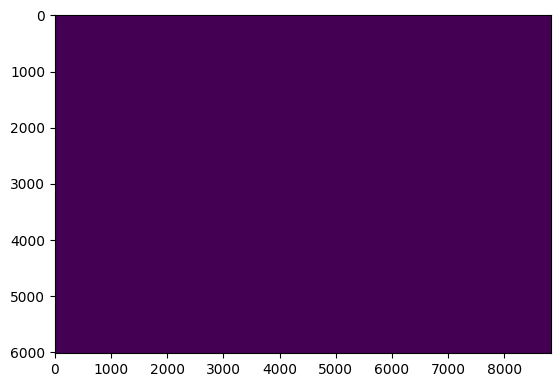

In [38]:
predictions = tf.sigmoid(logits).numpy()

whole_map_predictions = predictions.reshape(
    input_map.shape[0],
    input_map.shape[1],
    1
)
whole_map_predictions = whole_map_predictions * 255
whole_map_predictions = whole_map_predictions.astype(np.uint8)

plt.imshow(whole_map_predictions)